In [2]:
!git clone https://github.com/zonour97/Antidepressant_discontinuation.git

In [ ]:
!pip install -q scikit-plot

In [27]:
# comparison of ensemble of a fixed number features to single models fit on each set of features
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, auc, roc_curve, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, binarize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
#importing for gain
from scikitplot.helpers import cumulative_gain_curve
# for bbox anchor in legend
import pylab
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%matplotlib inline

In [2]:
path = "/content/drive/MyDrive/Ali_paper/Development/Data/"
pipline_labels = ["Drug aspects", "Drug aspects & demographic information", "Drug aspects & demographic information + Expressed ADRs"]

# Reading datasets

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Ali_paper/drug_discontinuation_9_variables.xlsx")
df1 = df.drop(["drug_id", "DXD-Stop", "age", "gender"], axis=1)
X1 = df1.to_numpy()
df2 = df.drop(["drug_id", "DXD-Stop"], axis=1)
X2 = df2.to_numpy()

y12 = df["DXD-Stop"].to_numpy()

In [4]:
df3 = pd.read_excel(path+'Most_informative_ADRs_identified_by_the_JMIM_method.xlsx')
df3_merge = pd.merge(df, df3, on=['drug_id', 'DXD-Stop'])
y3 = df3_merge['DXD-Stop'].to_numpy()
df_9f_jmim = df3_merge.drop(['drug_id', 'DXD-Stop'], axis=1)
df_9f_jmim = df_9f_jmim.rename(columns={"dosage_duration" : "Duration of medication intake",
                                        "Perceived_distress_ADR" : "Perceived distress from ADR",
                                        "rating" : "Patient's attiude",
                                        "Effectiveness-Ineffectiveness" : "Effectiveness",
                                        "ADR" : "Presence of ADR",
                                        "KN" : "Patient's lack of knowledge about medication",
                                        "DXD-Forgot" : "Patient's forgetfullness to use medication on time",
                                        "age" : "Age",
                                        "gender" : "Gender"})

In [5]:
#Resampling
oversample = SMOTE(random_state=50)
X1_new, y1_new = oversample.fit_resample(X1, y12)

# MinMax Scaler
t = MinMaxScaler()
X1_new_t = t.fit_transform(X1_new)
###############################################

#Resampling
oversample = SMOTE(random_state=50)
X2_new, y2_new = oversample.fit_resample(X2, y12)

# MinMax Scaler
t = MinMaxScaler()
X2_new_t = t.fit_transform(X2_new)
###############################################

#Resampling
X_9f_jmim = df_9f_jmim.to_numpy()
#Resampling
oversample = SMOTE(random_state=50)
X_9f_jmim_ov, y_9f_jmim_ov = oversample.fit_resample(X_9f_jmim, y3)

# MinMax Scaler
t = MinMaxScaler()
X_9f_jmim_ov_t = t.fit_transform(X_9f_jmim_ov)

# Classification function with Nested Cross-validation

In [6]:
def nested_cross_validation_with_diagram(clf1, clf2, clf3, X1, X2, X3, y1, y2, y3, params):
    # manual nested cross-validation for random forest on a classification dataset
    # to draw AUC
    step_array = np.arange (0, 1.01, 0.02)
    percentage = 100 - (100*step_array)
    percentages_cum_list = []
    gains_list = []
    # configure the cross-validation procedure
    auc_values = []
    sensitivities_list = []
    precisions_list = []
    fprs_list = []
    df_density_discon_list = []
    features = ["Drug aspects\n", "\nDrug aspects & demographic information:\n", "\nDrug aspects & demographic information + Expressed ADRs:\n"]
    for i, (X, y, clf) in enumerate(zip([X1, X2, X3], [y1, y2, y3], [clf1, clf2, clf3])):
        print(features[i])
        percentages_cum = []
        gains = []
        percentages_cum_shape = []

        auc_list = []
        sensitivities = []
        precisions = []
        fprs = []

        df_density_discon = pd.DataFrame(columns=['testy', 'Probability threshold'])

        pr_list = []
        re_list = []
        f1_list = []
        auc_list = []
        acc_list = []
        roc_auc_list = []
        cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
        for i, (train_ix, test_ix) in enumerate(cv_outer.split(X, y)):
            # split data
            X_train, X_test = X[train_ix, :], X[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]
            # configure the cross-validation procedure
            cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
            # define search
            search = GridSearchCV(clf, params, scoring='f1', cv=cv_inner, refit=True)
            # execute search
            result = search.fit(X_train, y_train)
            best_model = result.best_estimator_
            # calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
            best_model.fit(X_train, y_train)

            y_hat = best_model.predict(X_test)
            pr = precision_score(y_test, y_hat)
            pr_list.append(pr)
            re = recall_score(y_test, y_hat)
            re_list.append(re)
            f1 = f1_score(y_test, y_hat)
            f1_list.append(f1)
            acc = accuracy_score(y_test, y_hat)
            acc_list.append(acc)
            roc_auc = roc_auc_score(y_test, y_hat)
            roc_auc_list.append(roc_auc)
            # create dataframe for each density plot
            df_density = pd.DataFrame()
            df_density['testy'] = y_test
            df_density['Probability threshold'] = best_model.predict_proba(X_test)[:, 1]
            df_density_discon = pd.concat([df_density_discon, df_density]).reset_index(drop=True)
            # evaluate model on the hold out dataset
            yhat_prob1 = best_model.predict_proba(X_test)[:, 1]
            thesh_steps = np.quantile(yhat_prob1, step_array)
            thresholds = np.round(thesh_steps, 4)

            sensitivity = []
            precision = []
            fpr_list = []
            for thresh in  thresholds:
                y_pred_class = binarize([yhat_prob1], threshold = thresh)[0]
                confusion = confusion_matrix(y_test, y_pred_class)
                TP = confusion[1, 1]
                TN = confusion[0, 0]
                FP = confusion[0, 1]
                FN = confusion[1, 0]
                sens = TP/(TP+FN)
                prec = TP/(TP+FP)
                fpr  = FP/(TN+FP)
                sensitivity.append(sens)
                precision.append(prec)
                fpr_list.append(fpr)
            fprs.append(fpr_list)
            sensitivities.append(sensitivity)
            precisions.append(precision)
            # auc from sklearn
            false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yhat_prob1)
            auc_ = auc(false_positive_rate, true_positive_rate)
            auc_list.append(auc_)

            # Cumulative Gain
            classes = np.unique(y_test)
            percentage_cum, gain = cumulative_gain_curve(y_test, yhat_prob1, classes[1])
            percentages_cum_shape.append(percentage_cum.shape[0])
            percentages_cum.append(percentage_cum)
            gains.append(gain)

            # report progress
            print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
            print("precision={}, recall={}, f1-score={}, auc={}, accuracy={}, roc_auc={}".format(pr, re, f1, auc_, acc, roc_auc))
            print()
        print("mean_precision={} , mean_recall={}, mean_f1-score={}, mean_auc={}, mean_accuracy={}, mean_roc_auc={}".format(np.mean(pr_list), np.mean(re_list), np.mean(f1_list), np.mean(auc_list), np.mean(acc_list), np.mean(roc_auc_list)))
        print("std_precision={} , std_recall={}, std_f1-score={}, std_auc={}, std_accuracy={}, std_roc_auc={}".format(np.std(pr_list), np.std(re_list), np.std(f1_list), np.std(auc_list), np.std(acc_list), np.std(roc_auc_list)))
        percentages_cum_list.append([p_cum[:min(percentages_cum_shape)] for p_cum in percentages_cum])
        gains_list.append([gain_[:min(percentages_cum_shape)] for gain_ in gains])
        sensitivities_list.append(sensitivities)
        precisions_list.append(precisions)
        fprs_list.append(fprs)
        auc_values.append(np.mean(auc_list))
        df_density_discon_list.append(df_density_discon)
    return sensitivities_list, precisions_list, fprs_list, auc_values, gains_list, percentages_cum_list, df_density_discon_list

# Plot function

In [7]:
def plot_figures(sensitivities, precisions, fprs, auc, gains, percentages_cum, df_density_discon, colors, labels, bbox_to_anchor_roc, path_to_save):
    font = {'family' : 'Times New Roman','weight' : 'bold', 'size'  : 11}
    font_title = {'family' : 'Times New Roman', 'weight' : 'bold', 'size' : 13}
    step_array = np.arange (0, 1.01, 0.02)
    percentage = 100 - (100*step_array)

    fig, axs = plt.subplots(2, 3, figsize=(22, 12))

    sensitivities_1 = np.array(sensitivities[0])
    sensitivities_2 = np.array(sensitivities[1])
    sensitivities_3 = np.array(sensitivities[2])
    mean_sens_1 = np.mean(sensitivities_1, axis=0)
    mean_sens_2 = np.mean(sensitivities_2, axis=0)
    mean_sens_3 = np.mean(sensitivities_3, axis=0)

    precisions_1 = np.array(precisions[0])
    precisions_2 = np.array(precisions[1])
    precisions_3 = np.array(precisions[2])
    mean_prec_1 = np.mean(precisions_1, axis=0)
    mean_prec_2 = np.mean(precisions_2, axis=0)
    mean_prec_3 = np.mean(precisions_3, axis=0)

    fprs_1 = np.array(fprs[0])
    fprs_2 = np.array(fprs[1])
    fprs_3 = np.array(fprs[2])
    mean_fprs_1 = np.mean(fprs_1, axis=0)
    mean_fprs_2 = np.mean(fprs_2, axis=0)
    mean_fprs_3 = np.mean(fprs_3, axis=0)

    gains_1 = np.array(gains[0])
    gains_2 = np.array(gains[1])
    gains_3 = np.array(gains[2])
    mean_g_1 = np.mean(gains_1, axis=0)
    mean_g_2 = np.mean(gains_2, axis=0)
    mean_g_3 = np.mean(gains_3, axis=0)
    percentages_cum_1 = np.array(percentages_cum[0])
    percentages_cum_2 = np.array(percentages_cum[1])
    percentages_cum_3 = np.array(percentages_cum[2])
    mean_per_cum_1 = np.mean(percentages_cum_1, axis=0)
    mean_per_cum_2 = np.mean(percentages_cum_2, axis=0)
    mean_per_cum_3 = np.mean(percentages_cum_3, axis=0)

    im3 ,=axs[0, 0].plot(mean_fprs_3 * 100, mean_sens_3 * 100, color=colors[2], lw=3)
    im2 ,=axs[0, 0].plot(mean_fprs_2 * 100, mean_sens_2 * 100, color=colors[1], lw=3)
    im1 ,=axs[0, 0].plot(mean_fprs_1 * 100, mean_sens_1 * 100, color=colors[0], lw=3)
    axs[0, 0].plot([0, 100], [0, 100], linestyle="--", color="black", lw=1)
    axs[0, 0].set_title("A) ROC", fontdict=font_title, loc="left")
    axs[0, 0].set_xlabel("1-Specificity (%)", fontdict=font)
    axs[0, 0].set_ylabel("Sensitivity (%)", fontdict=font)
    axs[0, 0].yaxis.grid(True)
    # Hide the right and top spines
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[0, 0].yaxis.set_ticks_position('left')
    axs[0, 0].xaxis.set_ticks_position('bottom')
    # create blank rectangle
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    #Create organized list containing all handles for table. Extra represent empty space
    legend_handle = [extra, im3, im2, im1, extra, extra, extra, extra, extra, extra, extra, extra]
    #Define the labels
    label_row_1 = [" \n", " \n", " \n", " \n", r"$\bf{Features}$""\n", labels[2]+"\n", labels[1]+"\n", labels[0], r"$\bf{AUC}$""\n", "{:.2f}\n".format(auc[2]*100), "{:.2f}\n".format(auc[1]*100), "{:.2f}\n".format(auc[0]*100)]
    #organize labels for table construction
    legend_labels = np.concatenate([label_row_1])
    #Create legend
    axs[0, 0].legend(legend_handle, legend_labels, ncol = 3, shadow = True, handletextpad = -2, bbox_to_anchor=bbox_to_anchor_roc, prop={'size': 8})

    axs[0, 1].plot(mean_sens_3 * 100, mean_prec_3 * 100, color=colors[2], lw=3, label=labels[2])
    axs[0, 1].plot(mean_sens_2 * 100, mean_prec_2 * 100, color=colors[1], lw=3, label=labels[1])
    axs[0, 1].plot(mean_sens_1 * 100, mean_prec_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[0, 1].set_title("B) Precision vs Recall", fontdict=font_title, loc="left")
    axs[0, 1].set_xlabel("(Recall) Sensitivity (%)", fontdict=font)
    axs[0, 1].set_ylabel("(Precision) Positive predictive value (%)", fontdict=font)
    axs[0, 1].yaxis.grid(True)
    # axs[0, 1].legend(bbox_to_anchor=(0.7,0.37), shadow = True)
    # Hide the right and top spines
    axs[0, 1].spines['right'].set_visible(False)
    axs[0, 1].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[0, 1].yaxis.set_ticks_position('left')
    axs[0, 1].xaxis.set_ticks_position('bottom')

    axs[0, 2].plot(mean_per_cum_3 * 100, mean_g_3 * 100, color=colors[2], lw=3, label=labels[2])
    axs[0, 2].plot(mean_per_cum_2 * 100, mean_g_2 * 100, color=colors[1], lw=3, label=labels[1])
    axs[0, 2].plot(mean_per_cum_1 * 100, mean_g_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[0, 2].plot([0, 100], [0, 100], linestyle="--", color="black", lw=1)
    axs[0, 2].set_title("C) Cumulative Gains Curve", fontdict=font_title, loc="left")
    axs[0, 2].set_xlabel("Percentage of sample (%)", fontdict=font)
    axs[0, 2].set_ylabel("Gain (%)", fontdict=font)
    axs[0, 2].yaxis.grid(True)
    axs[0, 2].set(ylim=[-5, 105])
    # axs[0, 2].legend(bbox_to_anchor=(1.0,0.37), shadow = True)
    # Hide the right and top spines
    axs[0, 2].spines['right'].set_visible(False)
    axs[0, 2].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[0, 2].yaxis.set_ticks_position('left')
    axs[0, 2].xaxis.set_ticks_position('bottom')

    axs[1, 0].plot(percentage, mean_prec_3 * 100, color=colors[2], lw=3, label=labels[2])
    axs[1, 0].plot(percentage, mean_prec_2 * 100, color=colors[1], lw=3, label=labels[1])
    axs[1, 0].plot(percentage, mean_prec_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[1, 0].set_title("D) Positive Predictive Value", fontdict=font_title, loc="left")
    axs[1, 0].set_xlabel("Percentile of predicted probability", fontdict=font)
    axs[1, 0].set_ylabel("Positive predictive value (%)", fontdict=font)
    axs[1, 0].yaxis.grid(True)
    axs[1, 0].set(ylim=[-5, 105])
    axs[1, 0].legend(bbox_to_anchor=(1,0.37), shadow = True, prop={'size': 9.5})
    # Hide the right and top spines
    axs[1, 0].spines['right'].set_visible(False)
    axs[1, 0].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[1, 0].yaxis.set_ticks_position('left')
    axs[1, 0].xaxis.set_ticks_position('bottom')

    axs[1, 1].plot(percentage, mean_sens_3 * 100, color=colors[2], lw=3, label=labels[2])
    axs[1, 1].plot(percentage, mean_sens_2 * 100, color=colors[1], lw=3, label=labels[1])
    axs[1, 1].plot(percentage, mean_sens_1 * 100, color=colors[0], lw=3, label=labels[0])
    axs[1, 1].set_title("E) Sensitivity", fontdict=font_title, loc="left")
    axs[1, 1].set_xlabel("Percentile of predicted probability", fontdict=font)
    axs[1, 1].set_ylabel("Sensitivity (%)", fontdict=font)
    axs[1, 1].yaxis.grid(True)
    # axs[1, 1].legend(bbox_to_anchor=(0.12, 0.23), shadow = True)
    # Hide the right and top spines
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[1, 1].yaxis.set_ticks_position('left')
    axs[1, 1].xaxis.set_ticks_position('bottom')

    axs[1, 2] = sns.distplot(df_density_discon[df_density_discon["testy"] == 0]['Probability threshold'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'class 0')
    axs[1, 2] = sns.distplot(df_density_discon[df_density_discon["testy"] == 1]['Probability threshold'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'class 1')
    axs[1, 2].set_xlim(0, 1)
    axs[1, 2].yaxis.grid(True)
    # Hide the right and top spines
    axs[1, 2].spines['right'].set_visible(False)
    axs[1, 2].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axs[1, 2].yaxis.set_ticks_position('left')
    axs[1, 2].xaxis.set_ticks_position('bottom')
    axs[1, 2].legend(bbox_to_anchor=(0.6, 0.9), title="Entity type")
    axs[1, 2].set_title("F) Prediction Density", fontdict=font_title, loc="left")
    axs[1, 2].set_xlabel("Probability threshold", fontdict=font)
    axs[1, 2].set_ylabel("Density", fontdict=font)

    fig.savefig(path_to_save, bbox_inches='tight', dpi=300)
    plt.show()


# Classifiers

## Extra-Trees

In [ ]:
# # TO gain best random state
# rs_list = [0, 3, 31, 52, 55]
# for rs in rs_list:
#     print("random_strate:", rs)
#     params = {
#               "min_samples_split":[2, 5, 15],
#               "max_features":[1, 5, 10],
#               "n_estimators":[50, 500, 1000, 5000],
#               }

#     clf1 = ExtraTreesClassifier(random_state=rs)
#     clf2 = ExtraTreesClassifier(random_state=rs)
#     clf3 = ExtraTreesClassifier(random_state=rs)

#     sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
#                                                                                                           clf1, clf2, clf3,
#                                                                                                           X1_new_t, X2_new_t, X_9f_jmim_ov_t,
#                                                                                                           y1_new, y2_new, y_9f_jmim_ov, params)

random_strate: 0
Drug aspects

est=0.769, cfg={'max_features': 1, 'min_samples_split': 15, 'n_estimators': 500}
precision=0.7709923664122137, recall=0.7651515151515151, f1-score=0.7680608365019012, auc=0.8598197887970616, accuracy=0.7689393939393939, roc_auc=0.7689393939393939

est=0.768, cfg={'max_features': 1, 'min_samples_split': 2, 'n_estimators': 50}
precision=0.8031496062992126, recall=0.7727272727272727, f1-score=0.7876447876447876, auc=0.8314680899908172, accuracy=0.7916666666666666, roc_auc=0.7916666666666666

est=0.765, cfg={'max_features': 5, 'min_samples_split': 15, 'n_estimators': 5000}
precision=0.8, recall=0.7272727272727273, f1-score=0.761904761904762, auc=0.8615702479338843, accuracy=0.7727272727272727, roc_auc=0.7727272727272727

est=0.788, cfg={'max_features': 5, 'min_samples_split': 15, 'n_estimators': 5000}
precision=0.75, recall=0.75, f1-score=0.75, auc=0.8570437196391395, accuracy=0.7490494296577946, roc_auc=0.7490458015267175

est=0.778, cfg={'max_features': 1, 

In [ ]:
params = {
          "min_samples_split":[2, 5, 15],
          "max_features":[1, 5, 10],
          "n_estimators":[50, 500, 1000, 5000],
          }

clf1 = ExtraTreesClassifier(random_state=31)
clf2 = ExtraTreesClassifier(random_state=52)
clf3 = ExtraTreesClassifier(random_state=31)

sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
                                                                                                      clf1, clf2, clf3,
                                                                                                      X1_new_t, X2_new_t, X_9f_jmim_ov_t,
                                                                                                      y1_new, y2_new, y_9f_jmim_ov, params)

Drug aspects

est=0.783, cfg={'max_features': 5, 'min_samples_split': 15, 'n_estimators': 50}
precision=0.7751937984496124, recall=0.7575757575757576, f1-score=0.7662835249042146, auc=0.858442378328742, accuracy=0.7689393939393939, roc_auc=0.7689393939393939

est=0.773, cfg={'max_features': 10, 'min_samples_split': 2, 'n_estimators': 1000}
precision=0.8095238095238095, recall=0.7727272727272727, f1-score=0.7906976744186046, auc=0.8307793847566575, accuracy=0.7954545454545454, roc_auc=0.7954545454545454

est=0.762, cfg={'max_features': 10, 'min_samples_split': 15, 'n_estimators': 500}
precision=0.7950819672131147, recall=0.7348484848484849, f1-score=0.7637795275590552, auc=0.8584136822773185, accuracy=0.7727272727272727, roc_auc=0.7727272727272727

est=0.788, cfg={'max_features': 10, 'min_samples_split': 15, 'n_estimators': 1000}
precision=0.7555555555555555, recall=0.7727272727272727, f1-score=0.7640449438202247, auc=0.8565232477446217, accuracy=0.7604562737642585, roc_auc=0.7604094378

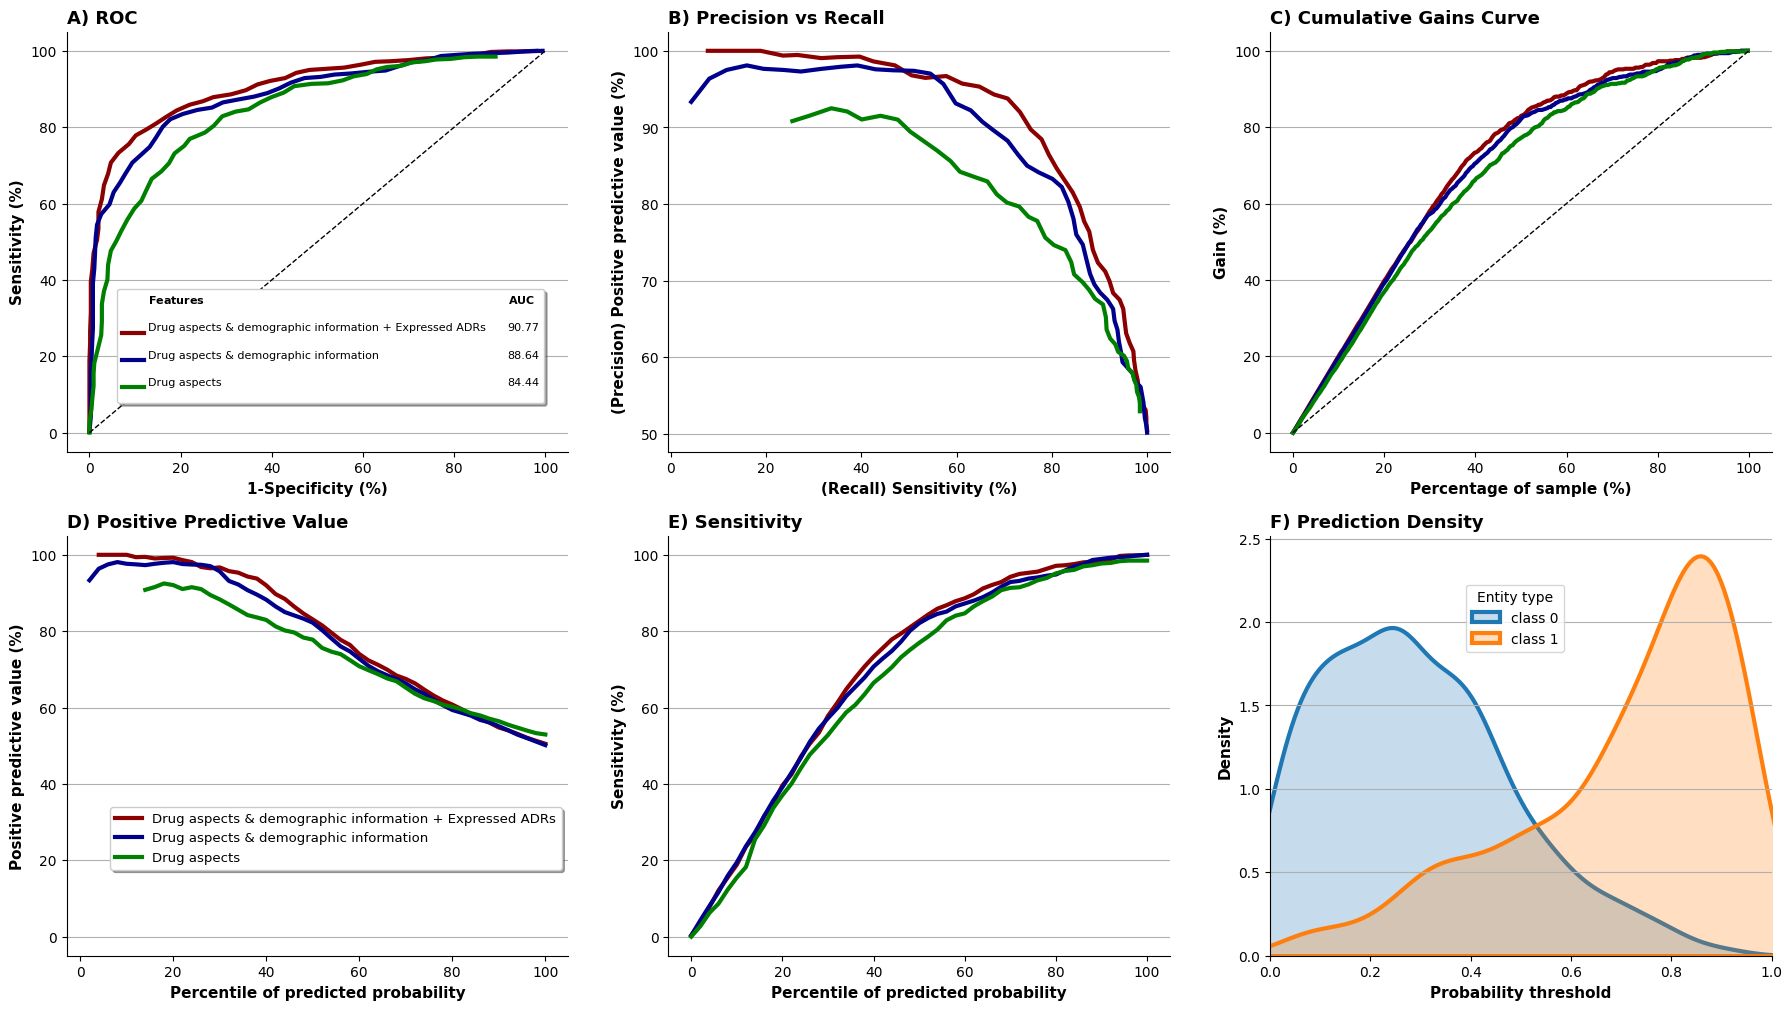

In [ ]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/ExtraTrees_diagrams.png'
color_list = ["green", "darkblue", "darkred"]
bbox_to_anchor_roc = (0.09, 0.4)
plot_figures(sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[2],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)

## Random Forest

In [ ]:
# rs_list = [0, 3, 31, 52, 55]
# for rs in rs_list:
#     print("random_strate:", rs)
#     params = {
#         'n_estimators' : [10, 100, 500, 1000],
#         'max_features' : [2, 4, 6, 8],
#         'criterion': ["gini", "entropy"],
#     }
#     clf1 = RandomForestClassifier(random_state=rs)
#     clf2 = RandomForestClassifier(random_state=rs)
#     clf3 = RandomForestClassifier(random_state=rs)
#     sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
#                                                                                                           clf1, clf2, clf3,
#                                                                                                           X1_new_t, X2_new_t, X_9f_jmim_ov_t,
#                                                                                                           y1_new, y2_new, y_9f_jmim_ov, params)

random_strate: 0
Drug aspects

est=0.751, cfg={'criterion': 'gini', 'max_features': 6, 'n_estimators': 1000}
precision=0.7795275590551181, recall=0.75, f1-score=0.7644787644787645, auc=0.841454315886134, accuracy=0.7689393939393939, roc_auc=0.7689393939393939

est=0.769, cfg={'criterion': 'entropy', 'max_features': 4, 'n_estimators': 500}
precision=0.7938931297709924, recall=0.7878787878787878, f1-score=0.7908745247148289, auc=0.8677972910927456, accuracy=0.7916666666666666, roc_auc=0.7916666666666666

est=0.759, cfg={'criterion': 'entropy', 'max_features': 6, 'n_estimators': 1000}
precision=0.776, recall=0.7348484848484849, f1-score=0.754863813229572, auc=0.8477100550964187, accuracy=0.7613636363636364, roc_auc=0.7613636363636364

est=0.755, cfg={'criterion': 'entropy', 'max_features': 6, 'n_estimators': 1000}
precision=0.7923076923076923, recall=0.7803030303030303, f1-score=0.7862595419847329, auc=0.8707494795281053, accuracy=0.7870722433460076, roc_auc=0.7870980800370113

est=0.777,

In [ ]:
params = {
    'n_estimators' : [10, 100, 500, 1000],
    'max_features' : [2, 4, 6, 8],
    'criterion': ["gini", "entropy"],
}
clf1 = RandomForestClassifier(random_state=52)
clf2 = RandomForestClassifier(random_state=31)
clf3 = RandomForestClassifier(random_state=31)
sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
                                                                                                      clf1, clf2, clf3,
                                                                                                      X1_new_t, X2_new_t, X_9f_jmim_ov_t,
                                                                                                      y1_new, y2_new, y_9f_jmim_ov, params)

Drug aspects

est=0.754, cfg={'criterion': 'gini', 'max_features': 8, 'n_estimators': 10}
precision=0.7603305785123967, recall=0.696969696969697, f1-score=0.7272727272727273, auc=0.8314967860422406, accuracy=0.7386363636363636, roc_auc=0.7386363636363635

est=0.764, cfg={'criterion': 'entropy', 'max_features': 4, 'n_estimators': 500}
precision=0.7906976744186046, recall=0.7727272727272727, f1-score=0.7816091954022988, auc=0.8678259871441689, accuracy=0.7840909090909091, roc_auc=0.784090909090909

est=0.763, cfg={'criterion': 'gini', 'max_features': 6, 'n_estimators': 1000}
precision=0.7698412698412699, recall=0.7348484848484849, f1-score=0.751937984496124, auc=0.8413969237832875, accuracy=0.7575757575757576, roc_auc=0.7575757575757576

est=0.754, cfg={'criterion': 'entropy', 'max_features': 2, 'n_estimators': 500}
precision=0.7923076923076923, recall=0.7803030303030303, f1-score=0.7862595419847329, auc=0.8655736756881794, accuracy=0.7870722433460076, roc_auc=0.7870980800370113

est=0.7

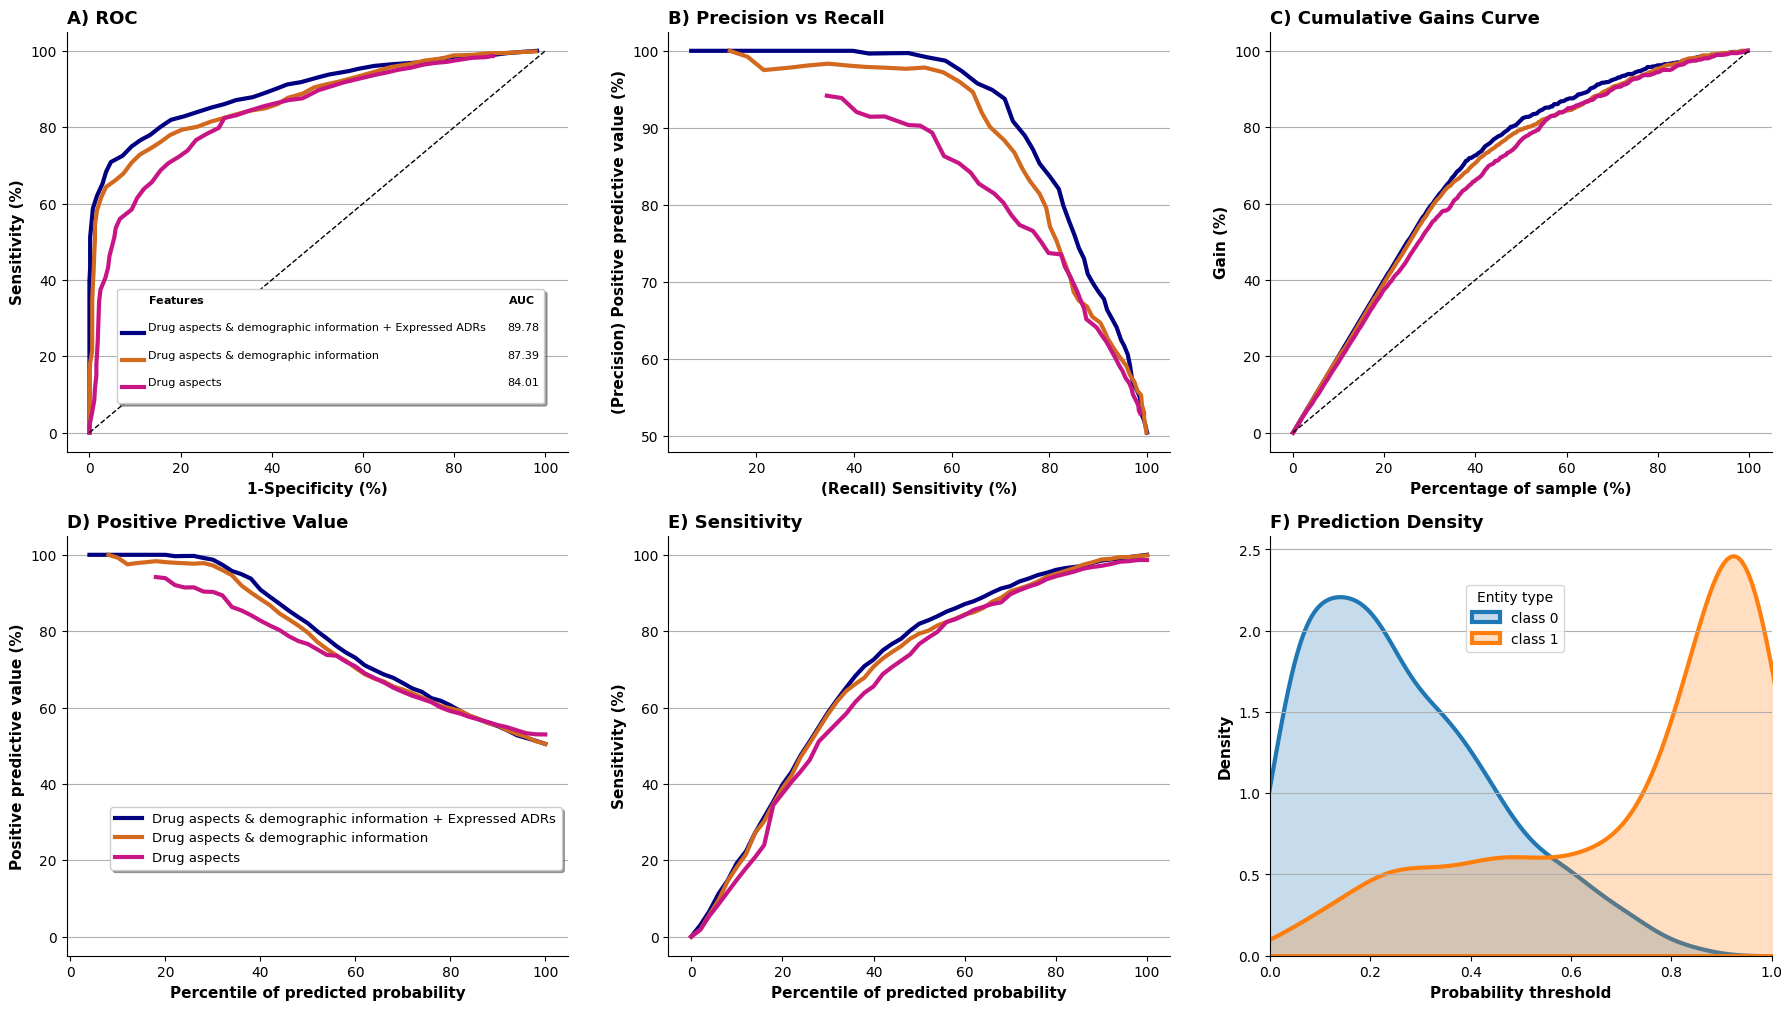

In [ ]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/Random_Forest_diagrams.png'
color_list = ["mediumvioletred", "chocolate", "navy"]
bbox_to_anchor_roc = (0.09, 0.4)
plot_figures(sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[2],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)

## XGBoost

In [ ]:
# rs_list = [0, 3, 31, 52, 55]
# for rs in rs_list:
#     print("random_strate:", rs)
#     params = {
#             'min_child_weight': [1, 5, 10],
#             'gamma': [0.5, 1, 1.5, 2, 5],
#             'subsample': [1.0, 0.8, 0.6],
#             'colsample_bytree': [0.6, 0.8, 1.0],
#             'max_depth': [3, 4, 5],
#             }

#     clf1 = XGBClassifier(random_state=rs)
#     clf2 = XGBClassifier(random_state=rs)
#     clf3 = XGBClassifier(random_state=rs)
#     sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
#                                                                                                       clf1, clf2, clf3,
#                                                                                                       X1_new_t, X2_new_t, X_9f_jmim_ov_t,
#                                                                                                       y1_new, y2_new, y_9f_jmim_ov, params)

random_strate: 0
Drug aspects

est=0.791, cfg={'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
precision=0.8620689655172413, recall=0.7575757575757576, f1-score=0.8064516129032258, auc=0.8812557392102845, accuracy=0.8181818181818182, roc_auc=0.8181818181818181

est=0.790, cfg={'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}
precision=0.8015267175572519, recall=0.7954545454545454, f1-score=0.7984790874524715, auc=0.8925332874196512, accuracy=0.7992424242424242, roc_auc=0.7992424242424242

est=0.787, cfg={'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
precision=0.7835820895522388, recall=0.7954545454545454, f1-score=0.7894736842105262, auc=0.8770087235996327, accuracy=0.7878787878787878, roc_auc=0.7878787878787878

est=0.797, cfg={'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
precision=0.81203007518796

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [1.0, 0.8, 0.6],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        }

clf1 = XGBClassifier(random_state=0)
clf2 = XGBClassifier(random_state=3)
clf3 = XGBClassifier(random_state=31)
sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
                                                                                                      clf1, clf2, clf3,
                                                                                                      X1_new_t, X2_new_t, X_9f_jmim_ov_t,
                                                                                                      y1_new, y2_new, y_9f_jmim_ov, params)

Drug aspects

est=0.791, cfg={'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
precision=0.8620689655172413, recall=0.7575757575757576, f1-score=0.8064516129032258, auc=0.8812557392102845, accuracy=0.8181818181818182, roc_auc=0.8181818181818181

est=0.790, cfg={'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0}
precision=0.8015267175572519, recall=0.7954545454545454, f1-score=0.7984790874524715, auc=0.8925332874196512, accuracy=0.7992424242424242, roc_auc=0.7992424242424242

est=0.787, cfg={'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
precision=0.7835820895522388, recall=0.7954545454545454, f1-score=0.7894736842105262, auc=0.8770087235996327, accuracy=0.7878787878787878, roc_auc=0.7878787878787878

est=0.797, cfg={'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}
precision=0.8120300751879699, recall=0.8181

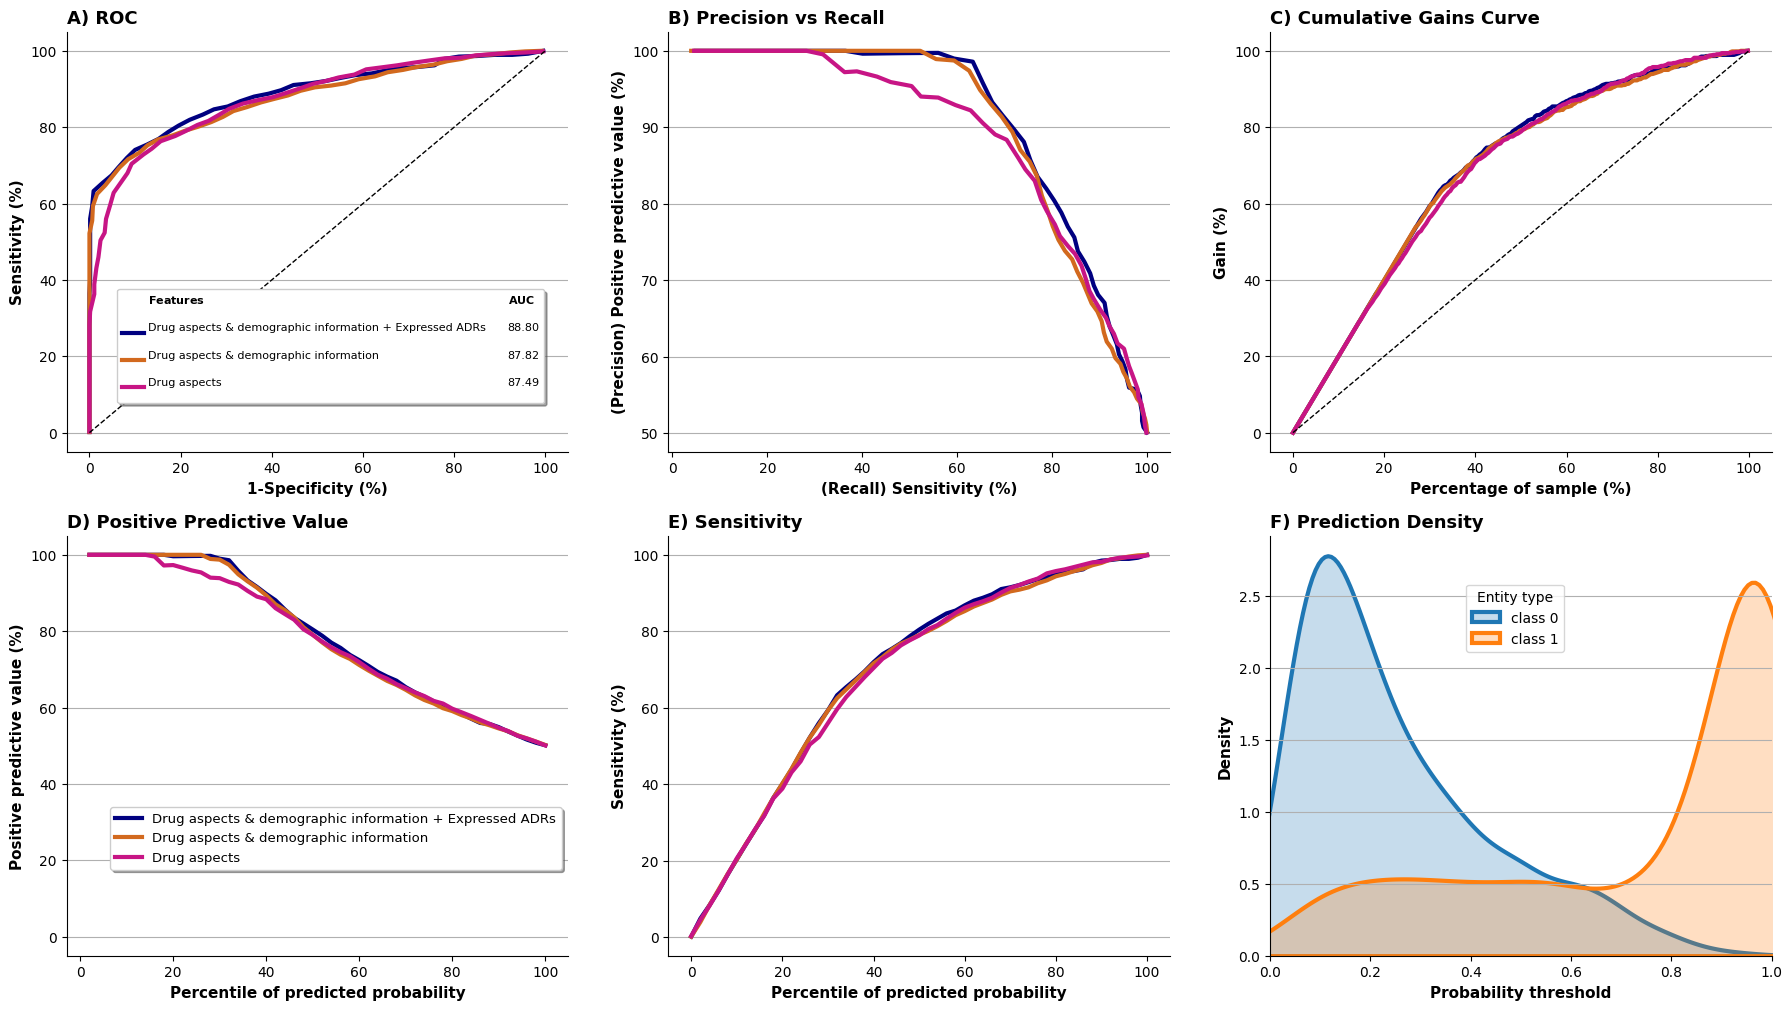

In [ ]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/XGBoost_diagrams.png'
color_list = ["mediumvioletred", "chocolate", "navy"]
bbox_to_anchor_roc = (0.09, 0.4)
plot_figures(sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[2],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)

## AdaBoost

In [ ]:
# All random states have the same results in AdaBoost.

In [ ]:
params={
        'n_estimators' : [500, 1000, 2000, 5000],
        'learning_rate' : [.001,0.01,.1],
        }
clf1 = AdaBoostClassifier(random_state=52)
clf2 = AdaBoostClassifier(random_state=52)
clf3 = AdaBoostClassifier(random_state=52)
sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
                                                                                                      clf1, clf2, clf3,
                                                                                                      X1_new_t, X2_new_t, X_9f_jmim_ov_t,
                                                                                                      y1_new, y2_new, y_9f_jmim_ov, params)

Drug aspects

est=0.776, cfg={'learning_rate': 0.1, 'n_estimators': 5000}
precision=0.8217054263565892, recall=0.803030303030303, f1-score=0.8122605363984674, auc=0.8815426997245179, accuracy=0.8143939393939394, roc_auc=0.8143939393939392

est=0.774, cfg={'learning_rate': 0.1, 'n_estimators': 5000}
precision=0.7692307692307693, recall=0.7575757575757576, f1-score=0.7633587786259541, auc=0.8721877869605141, accuracy=0.7651515151515151, roc_auc=0.7651515151515151

est=0.755, cfg={'learning_rate': 0.1, 'n_estimators': 2000}
precision=0.7874015748031497, recall=0.7575757575757576, f1-score=0.7722007722007722, auc=0.8613119834710743, accuracy=0.7765151515151515, roc_auc=0.7765151515151515

est=0.775, cfg={'learning_rate': 0.1, 'n_estimators': 5000}
precision=0.7697841726618705, recall=0.8106060606060606, f1-score=0.7896678966789666, auc=0.873380754105945, accuracy=0.7832699619771863, roc_auc=0.7831656257228776

est=0.790, cfg={'learning_rate': 0.1, 'n_estimators': 5000}
precision=0.82142857

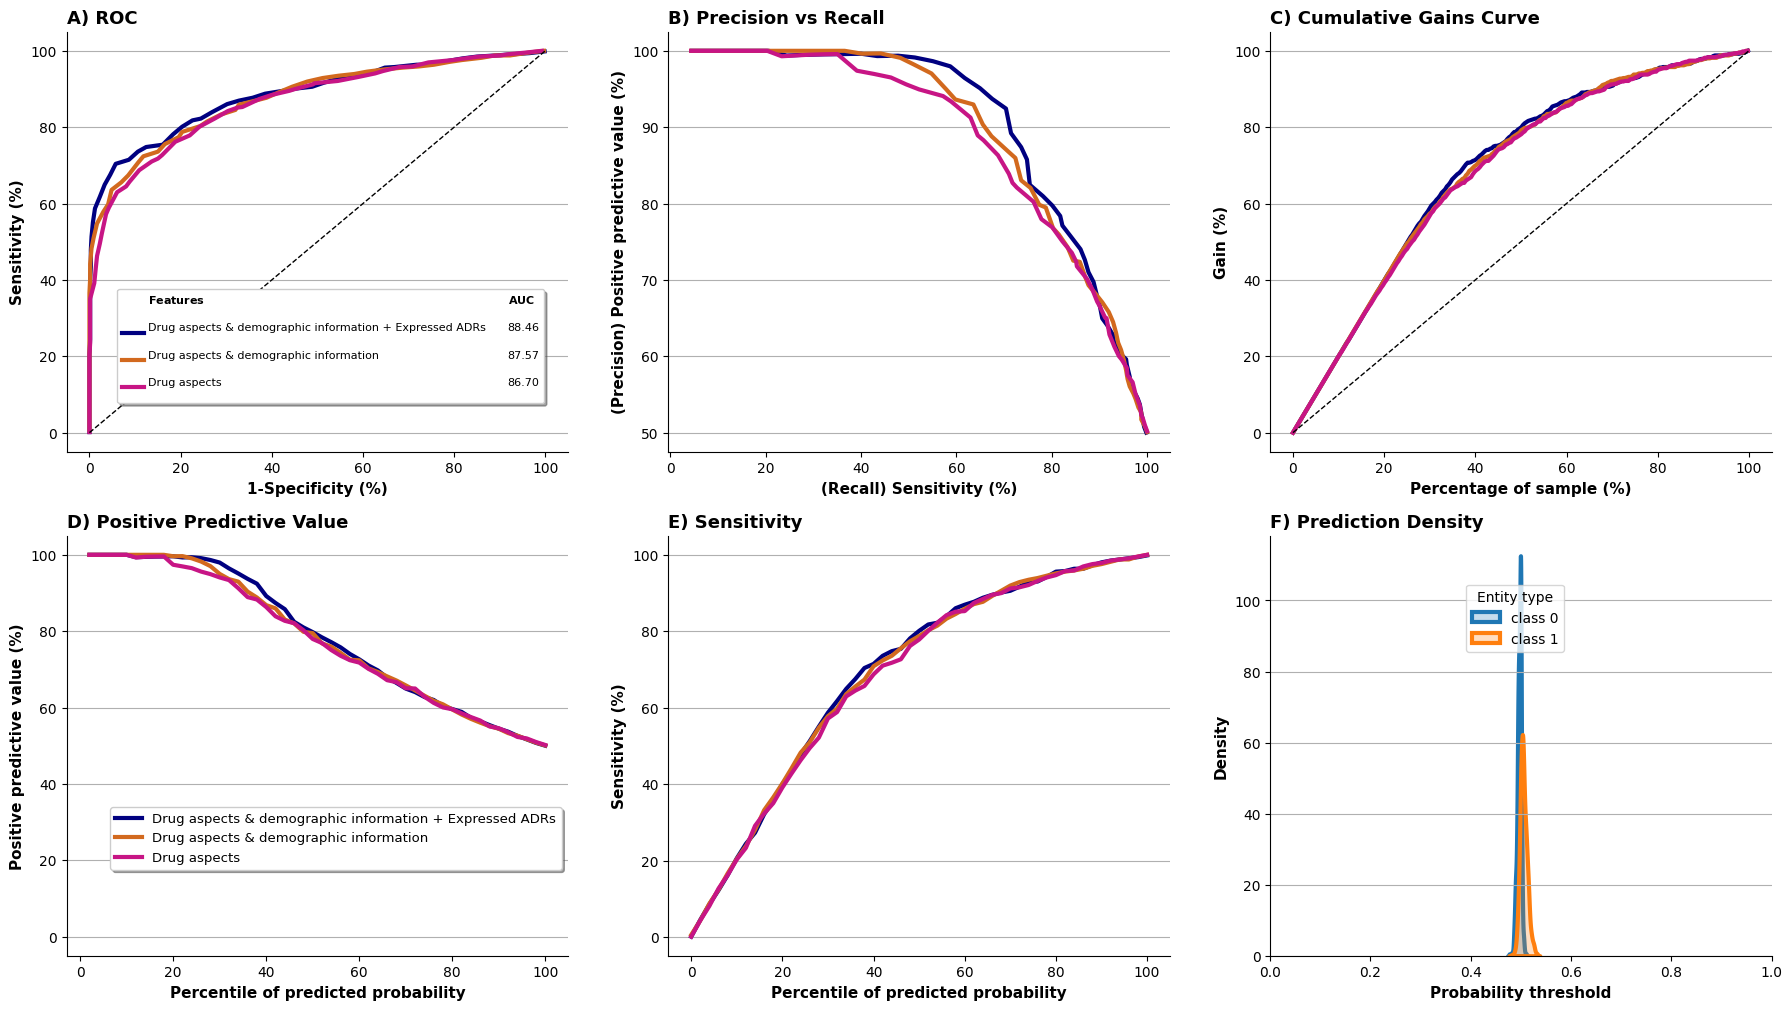

In [ ]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/AdaBoost_diagrams.png'
color_list = ["mediumvioletred", "chocolate", "navy"]
bbox_to_anchor_roc = (0.09, 0.4)
plot_figures(sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[2],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)

## SVM

In [ ]:
# All random states have the same results in SVM.

In [ ]:
params = {
    "kernel": ["poly", "rbf", "linear"],
    "degree": [2, 4, 8],
    "gamma": ["scale", "auto"],
}
clf1 = SVC(probability=True)
clf2 = SVC(probability=True)
clf3 = SVC(probability=True)
sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
                                                                                                      clf1, clf2, clf3,
                                                                                                      X1_new_t, X2_new_t, X_9f_jmim_ov_t,
                                                                                                      y1_new, y2_new, y_9f_jmim_ov, params)

Drug aspects

est=0.706, cfg={'degree': 8, 'gamma': 'scale', 'kernel': 'poly'}
precision=0.7006802721088435, recall=0.7803030303030303, f1-score=0.7383512544802867, auc=0.7784664830119375, accuracy=0.7234848484848485, roc_auc=0.7234848484848486

est=0.703, cfg={'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
precision=0.68, recall=0.7727272727272727, f1-score=0.7234042553191491, auc=0.7615358126721763, accuracy=0.7045454545454546, roc_auc=0.7045454545454545

est=0.707, cfg={'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
precision=0.6280487804878049, recall=0.7803030303030303, f1-score=0.6959459459459459, auc=0.7505165289256199, accuracy=0.6590909090909091, roc_auc=0.659090909090909

est=0.706, cfg={'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
precision=0.6410256410256411, recall=0.7575757575757576, f1-score=0.6944444444444444, auc=0.7095477677538746, accuracy=0.6653992395437263, roc_auc=0.6650474207726116

est=0.708, cfg={'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
precision=0

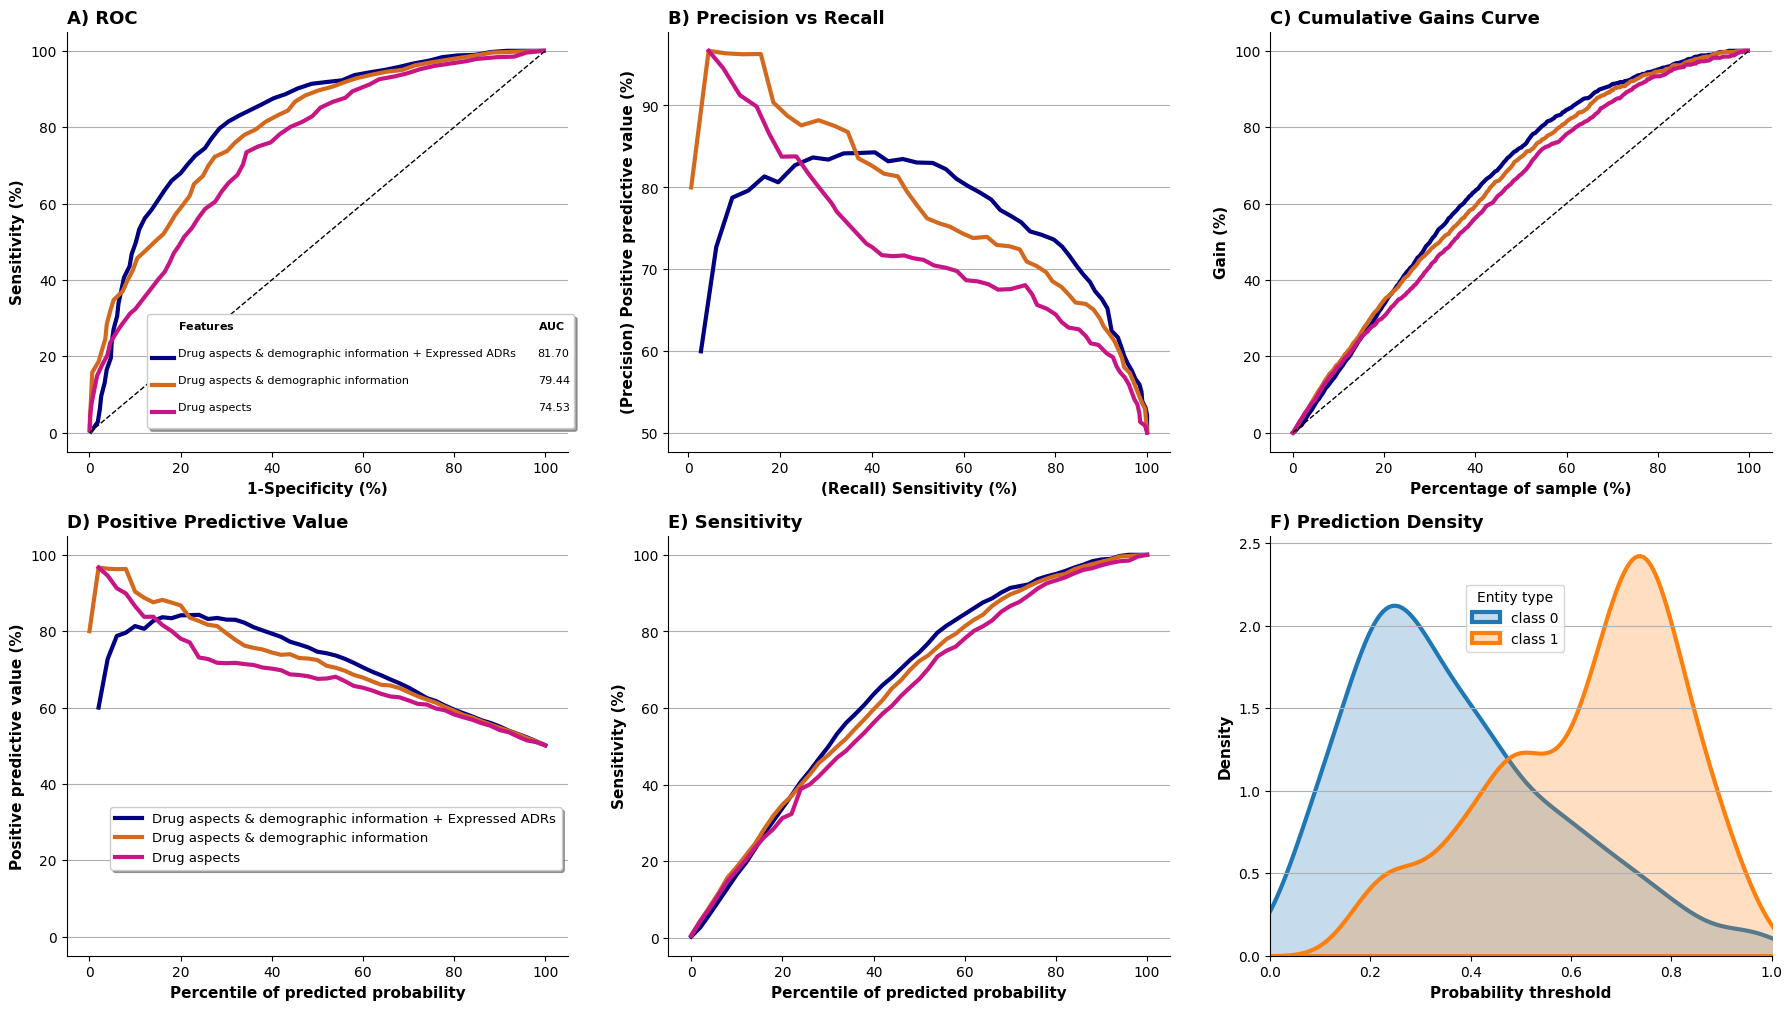

In [ ]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/SVM_diagrams.png'
color_list = ["mediumvioletred", "chocolate", "navy"]
bbox_to_anchor_roc = (0.15, 0.34)
plot_figures(sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[2],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)

## LR

In [ ]:
# All random states have the same results in LR.

In [ ]:
params = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.1, 1, 10]
}
clf1 = LogisticRegression()
clf2 = LogisticRegression()
clf3 = LogisticRegression()
sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list = nested_cross_validation_with_diagram(
                                                                                                      clf1, clf2, clf3,
                                                                                                      X1_new_t, X2_new_t, X_9f_jmim_ov_t,
                                                                                                      y1_new, y2_new, y_9f_jmim_ov, params)

Drug aspects

est=0.664, cfg={'C': 10, 'penalty': 'l2'}
precision=0.673469387755102, recall=0.75, f1-score=0.7096774193548386, auc=0.7706324609733701, accuracy=0.6931818181818182, roc_auc=0.6931818181818181

est=0.677, cfg={'C': 1, 'penalty': 'l2'}
precision=0.6280487804878049, recall=0.7803030303030303, f1-score=0.6959459459459459, auc=0.711662075298439, accuracy=0.6590909090909091, roc_auc=0.659090909090909

est=0.677, cfg={'C': 10, 'penalty': 'l2'}
precision=0.6597222222222222, recall=0.7196969696969697, f1-score=0.6884057971014492, auc=0.7284205693296603, accuracy=0.6742424242424242, roc_auc=0.6742424242424242

est=0.677, cfg={'C': 10, 'penalty': 'l2'}
precision=0.6153846153846154, recall=0.7272727272727273, f1-score=0.6666666666666667, auc=0.6790423317140875, accuracy=0.6349809885931559, roc_auc=0.6346287300485774

est=0.687, cfg={'C': 10, 'penalty': 'l2'}
precision=0.6099290780141844, recall=0.6564885496183206, f1-score=0.6323529411764706, auc=0.7075526254915568, accuracy=0.61977

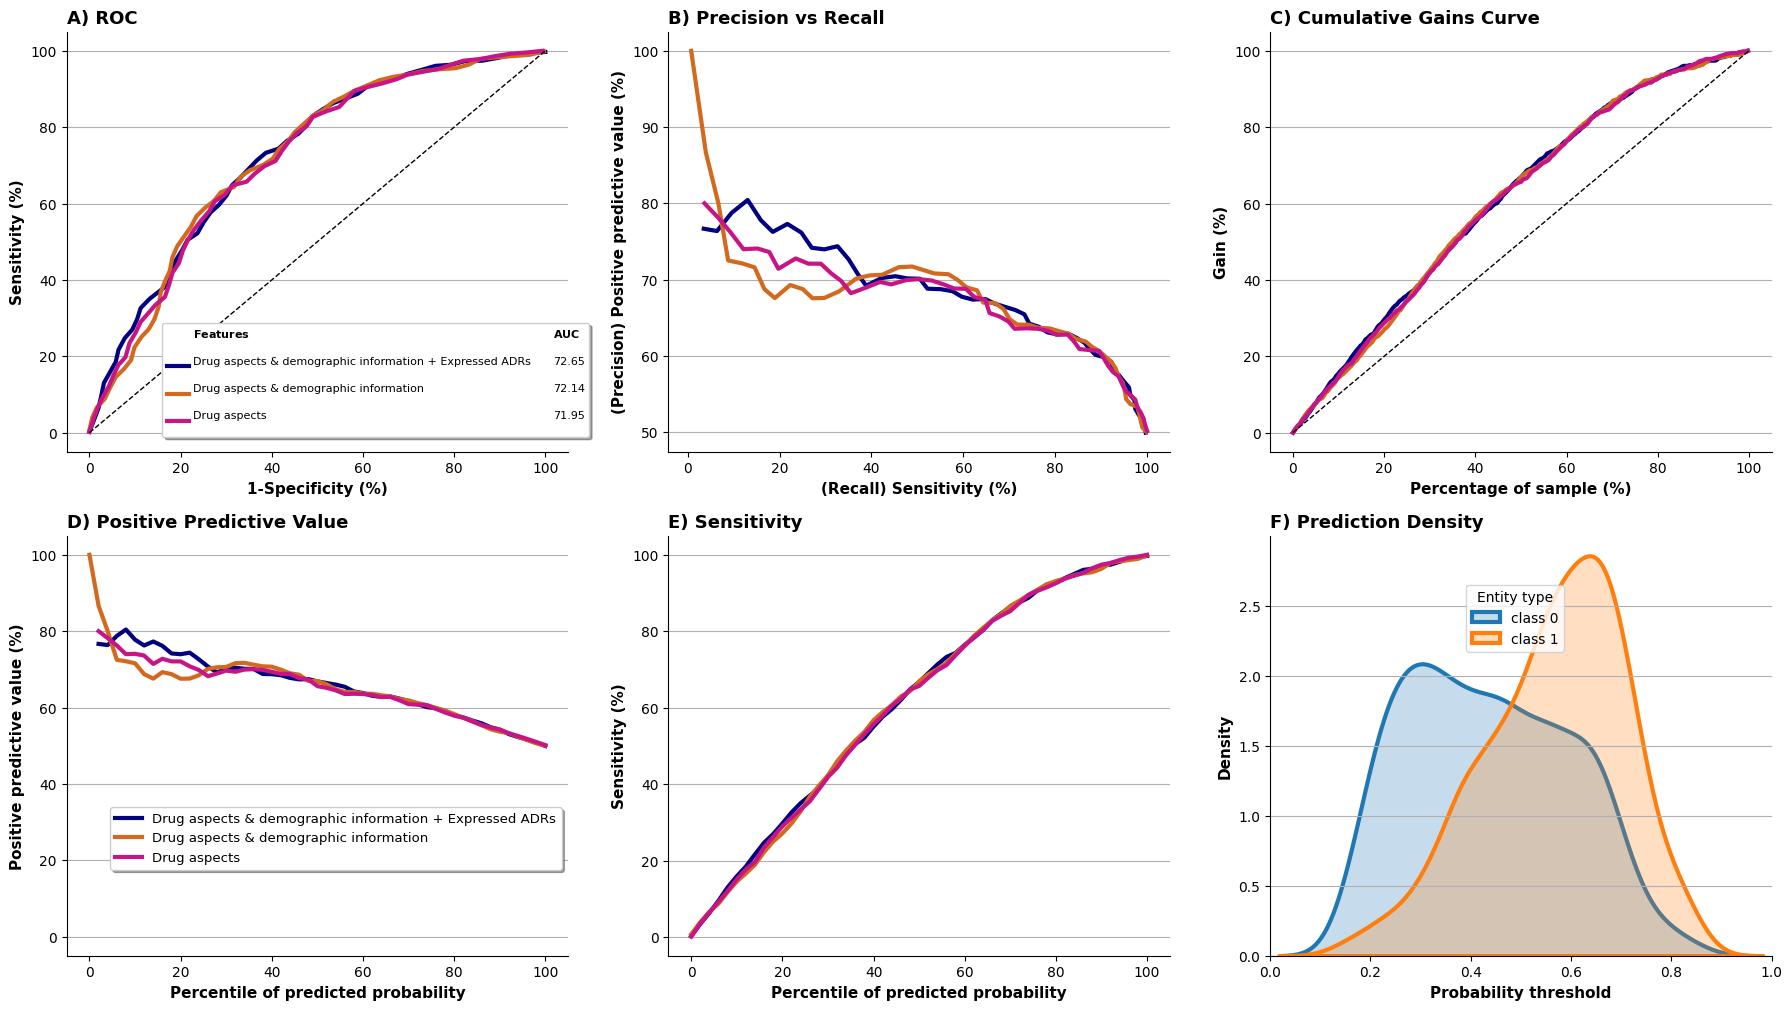

In [ ]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/Logistic_Regression_diagrams.png'
color_list = ["mediumvioletred", "chocolate", "navy"]
bbox_to_anchor_roc = (0.18, 0.32)
plot_figures(sens_list, prec_list, fpr_list, auc_list, gains_list, percentages_cum_list, df_density_discon_list[2],
                                                                                color_list, pipline_labels, bbox_to_anchor_roc, path_to_save)

# Feature_importances of 25 features

In [62]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() - 0.25
                value = np.round(p.get_width(), 3)
                if str(_x)=="nan":
                    continue
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.25
                value = np.round(p.get_width(), 3)
                if str(_x)=="nan":
                    continue
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def plot_feature_importances(df_variables_value, classifier_name, color_name, path_to_save):
    # plt.figure(figsize=(8, 6))
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(y="Explanatory variables", x="Feature importances", data=df_variables_value, dodge=False, color=color_name)
    show_values_on_bars(ax, h_v="h", space=0.001)
    ax.yaxis.grid(True)
    # ax.legend(loc="lower right")
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(0, 0.15)
    ax.set_title('Fearture importances based on {} classifier'.format(classifier_name))
    ax.grid()
    plt.savefig(path_to_save, bbox_inches='tight', dpi=1000)
    plt.show()

def Classifier_Feature_importances(clf, df_features, X, y, params):
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
    feature_importances = []
    for i, (train_ix, test_ix) in enumerate(cv_outer.split(X, y)):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
        # define search
        search = GridSearchCV(clf, params, scoring='f1', cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)
        best_model = result.best_estimator_
        best_model.fit(X_train, y_train)
        # get feature importances and add to list
        feature_importances.append(best_model.feature_importances_)
    # average feature importances over all outer folds
    feature_importances = np.mean(feature_importances, axis=0)

    df_variables_value = pd.DataFrame(columns=['Explanatory variables', 'Feature importances'])
    df_variables_value['Explanatory variables'] = df_features.columns.tolist()
    df_variables_value['Feature importances'] = feature_importances
    df_variables_value = df_variables_value.sort_values('Feature importances', ascending=False)
    return df_variables_value

## Extra-Trees

In [58]:
params = {
          "min_samples_split":[2, 5, 15],
          "max_features":[1, 5, 10],
          "n_estimators":[50, 500, 1000, 5000],
          }

clf = ExtraTreesClassifier(random_state=31)

df_variables_value_EXT = Classifier_Feature_importances(clf, df_9f_jmim, X_9f_jmim_ov_t, y_9f_jmim_ov, params)
df_variables_value_EXT.to_excel(path+'Extra-Trees_feature_importance.xlsx', index=False)

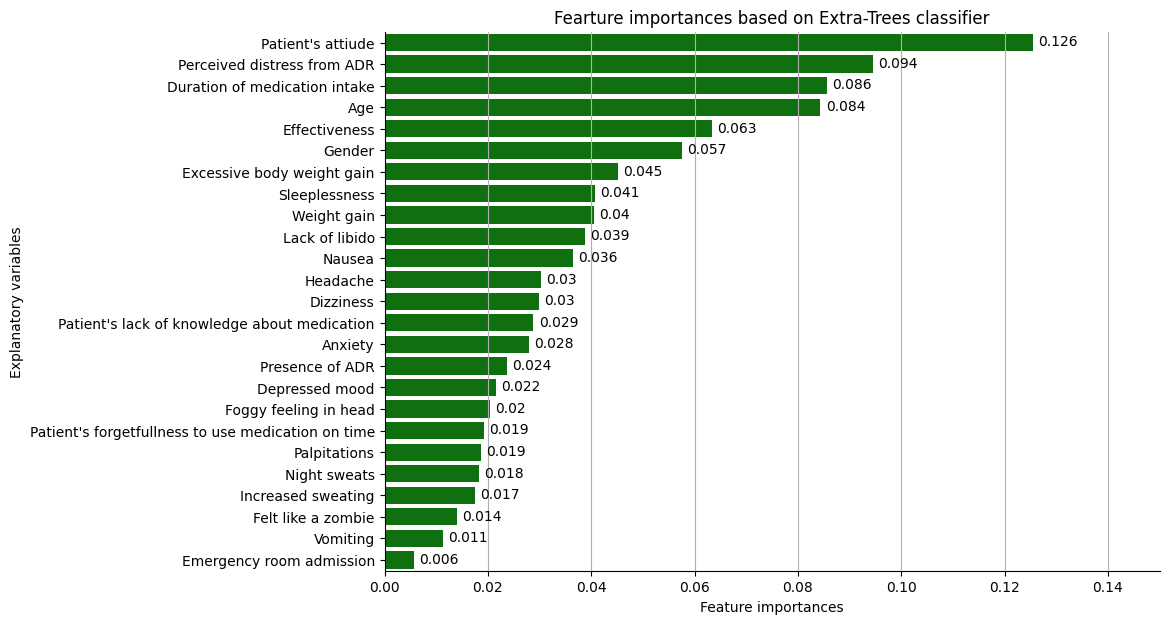

In [63]:
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/Extra-Trees_feature_importances.png'
# plot feature importance
plot_feature_importances(df_variables_value_EXT, 'Extra-Trees', 'green', path_to_save)

## Random Forest

In [60]:
params = {
    'n_estimators' : [10, 100, 500, 1000],
    'max_features' : [2, 4, 6, 8],
    'criterion': ["gini", "entropy"],
}

clf = RandomForestClassifier(random_state=31)
path_to_save = '/content/drive/MyDrive/Ali_paper/Development/Images_and_tabels/Random_Forest_feature_importances.png'
df_variables_value_RF = Classifier_Feature_importances(clf, df_9f_jmim, X_9f_jmim_ov_t, y_9f_jmim_ov, params)
df_variables_value_RF.to_excel(path+'Random_Forest_feature_importance.xlsx', index=False)

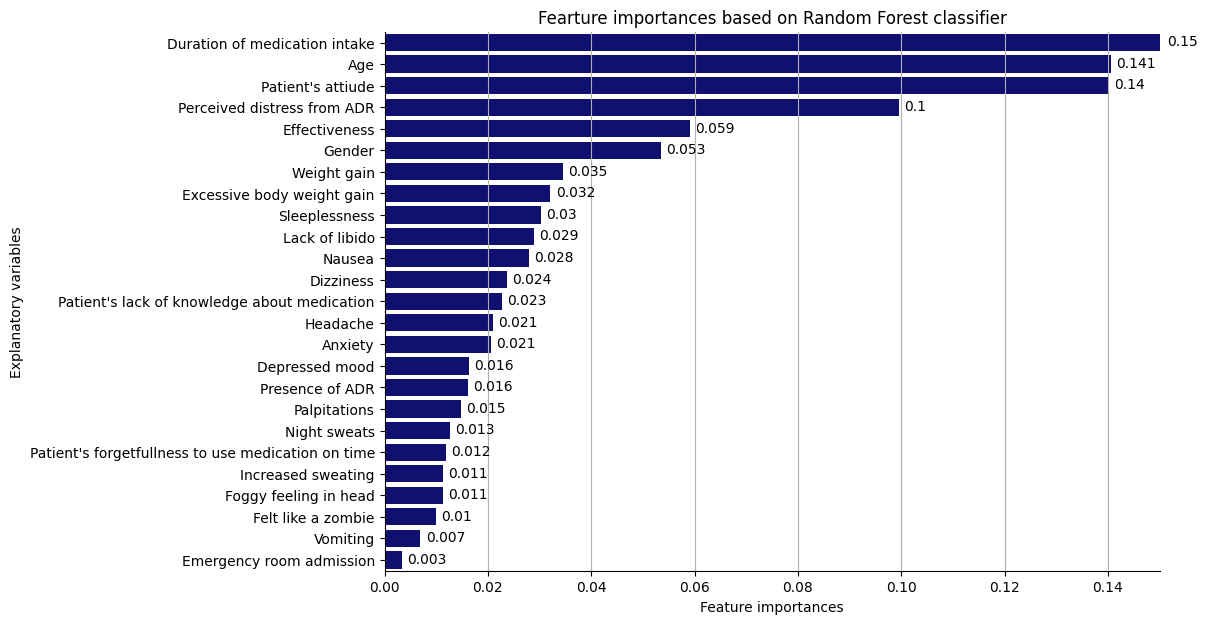

In [64]:
# plot feature importance
plot_feature_importances(df_variables_value_RF, 'Random Forest', 'navy', path_to_save)